In [1]:
import sys
import os
sys.path.append(os.path.abspath("../"))  # or "../../" depending on location
from setup import add_project_root
add_project_root()

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from models.forward.FNO_models import FNO, FNO_noGrad
from models.forward.CNO_models import CNO
import time
import japanize_matplotlib
from notebooks.evaluate_functions import *

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
# Load data
test_data = torch.load('../data/datasets/data/darcy_test_16.pt')
test_data_32 = torch.load("../data/datasets/data/darcy_test_32.pt")
x_test = test_data["x"].unsqueeze(1).float()
y_test = test_data["y"].unsqueeze(1).float()
x_test_32 = test_data_32["x"].unsqueeze(1).float()
y_test_32 = test_data_32["y"].unsqueeze(1).float()


In [4]:
# Load models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cno = CNO(1, 1, 32).to(device)
cno.load_state_dict(torch.load("../results/forward/checkpoints/best_darcy_cno_model.pth", map_location=device))
cno.eval()

fno = FNO(modes1=8, modes2=8, width=32).to(device)
fno.load_state_dict(torch.load("../results/forward/checkpoints/best_darcy_fno_model.pth", map_location=device))
fno.eval()


x_test = x_test.to(device)
y_test = y_test.to(device)

x_test_32 = x_test_32.to(device)
y_test_32 = y_test_32.to(device)


In [5]:
# inference test data(16 x 16)

inference_times = {}
metrics = {}
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 推論時間の評価に興味がない場合は、warmupとrepeatを0に設定してください。
warmup = 10
repeat = 1000

with torch.no_grad():

    # CNO
    pred_cno = cno(x_test).cpu().numpy()
    inference_times["CNO"] = measure_inference_time(cno, x_test,warmup=warmup,repeat=repeat)
    metrics["CNO"] = evaluate(pred_cno, y_test.cpu().numpy())
    print(f"Number of parameters in CNO: {count_params(cno)}")



    # FNO
    x_test_fno = x_test.permute(0, 2, 3, 1)  # (B, H, W, 1)
    pred_fno = fno(x_test_fno).cpu().numpy()
    inference_times["FNO"] = measure_inference_time(fno, x_test_fno,warmup=warmup,repeat=repeat)
    metrics["FNO"] = evaluate(pred_fno, y_test.cpu().numpy())
    print(f"Number of parameters in FNO: {count_params(fno)}")
    
    y_true = y_test.cpu().numpy()
    

    


print_inference_and_metrics(inference_times,metrics)




Number of parameters in CNO: 416481
Number of parameters in FNO: 204257
【評価結果】

【推論時間（ms）】
CNO            : 0.64 ms
FNO            : 0.86 ms

【評価指標】
Model                    MSE       PSNR       SSIM       HF_MSE
-----------------------------------------------------------------
CNO               3.0251e-03      25.19     0.9792   1.7452e-01
FNO               1.8002e-01      20.96     0.9432   4.5290e+01


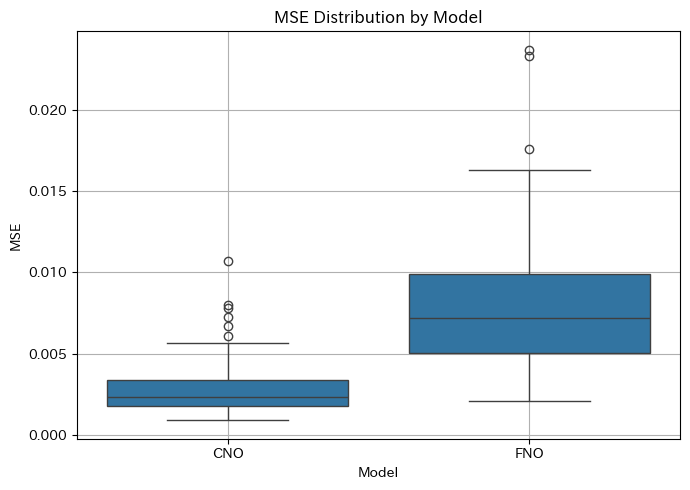

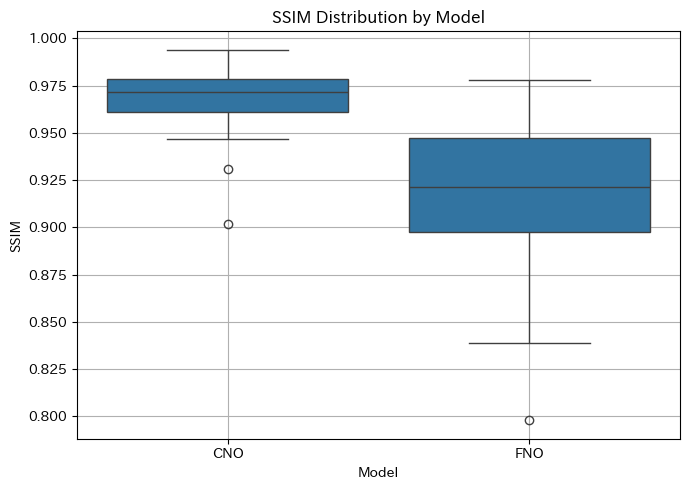

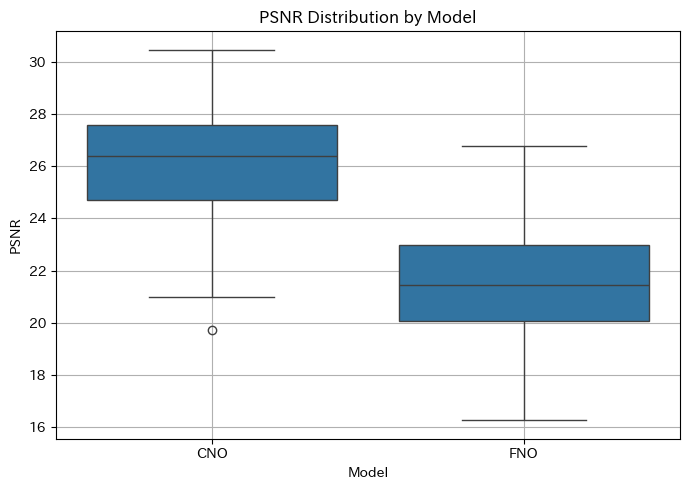

In [6]:
# evaluate per sample
# evaluate per sample
scores_cno = evaluate_all(pred_cno, y_test)
scores_fno = evaluate_all(pred_fno, y_test)

# --- スコア抽出 ---
mse_cno = [s["MSE"] for s in scores_cno]
mse_fno = [s["MSE"] for s in scores_fno]
ssim_cno = [s["SSIM"] for s in scores_cno]
ssim_fno = [s["SSIM"] for s in scores_fno]
psnr_cno = [s["PSNR"] for s in scores_cno]
psnr_fno = [s["PSNR"] for s in scores_fno]

boxplot_metric_comparison({"CNO": mse_cno, "FNO": mse_fno}, metric_name="MSE")
boxplot_metric_comparison({"CNO": ssim_cno, "FNO": ssim_fno}, metric_name="SSIM")
boxplot_metric_comparison({"CNO": psnr_cno, "FNO": psnr_fno}, metric_name="PSNR")


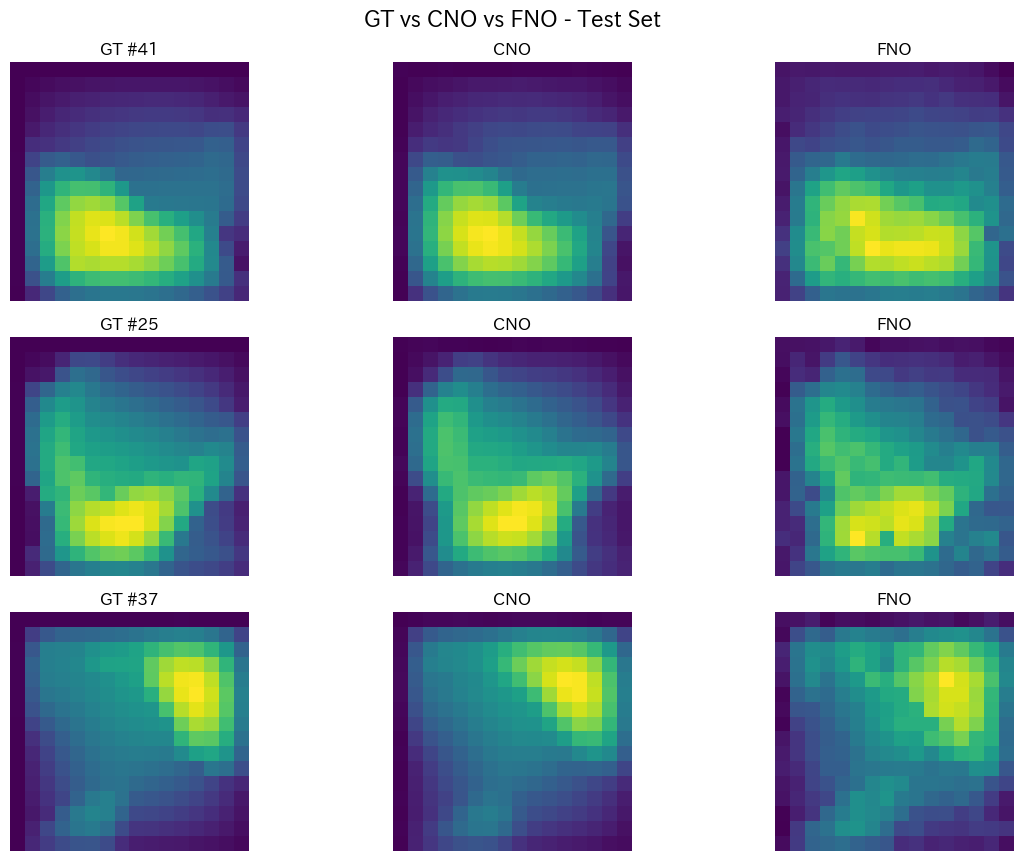

In [7]:
# visualize prediction samples
gt_images = y_true.squeeze(1)                    # [B, 1, H, W] → [B, H, W]  
cno_images = pred_cno.squeeze(1)              # [B, 1, H, W]
fno_images = pred_fno.squeeze(-1)                # [B, H, W, 1]

preds = [cno_images,  fno_images]
labels = ["CNO", "FNO"]
plot_gt_pred_comparison(gt_images,preds,labels, num_samples=3, title="GT vs CNO vs FNO - Test Set")

c:\Users\natsu\OneDrive - 国立大学法人東北大学\研究室\python\FNOorCNN\root\notebooks\evaluate_functions.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.94])


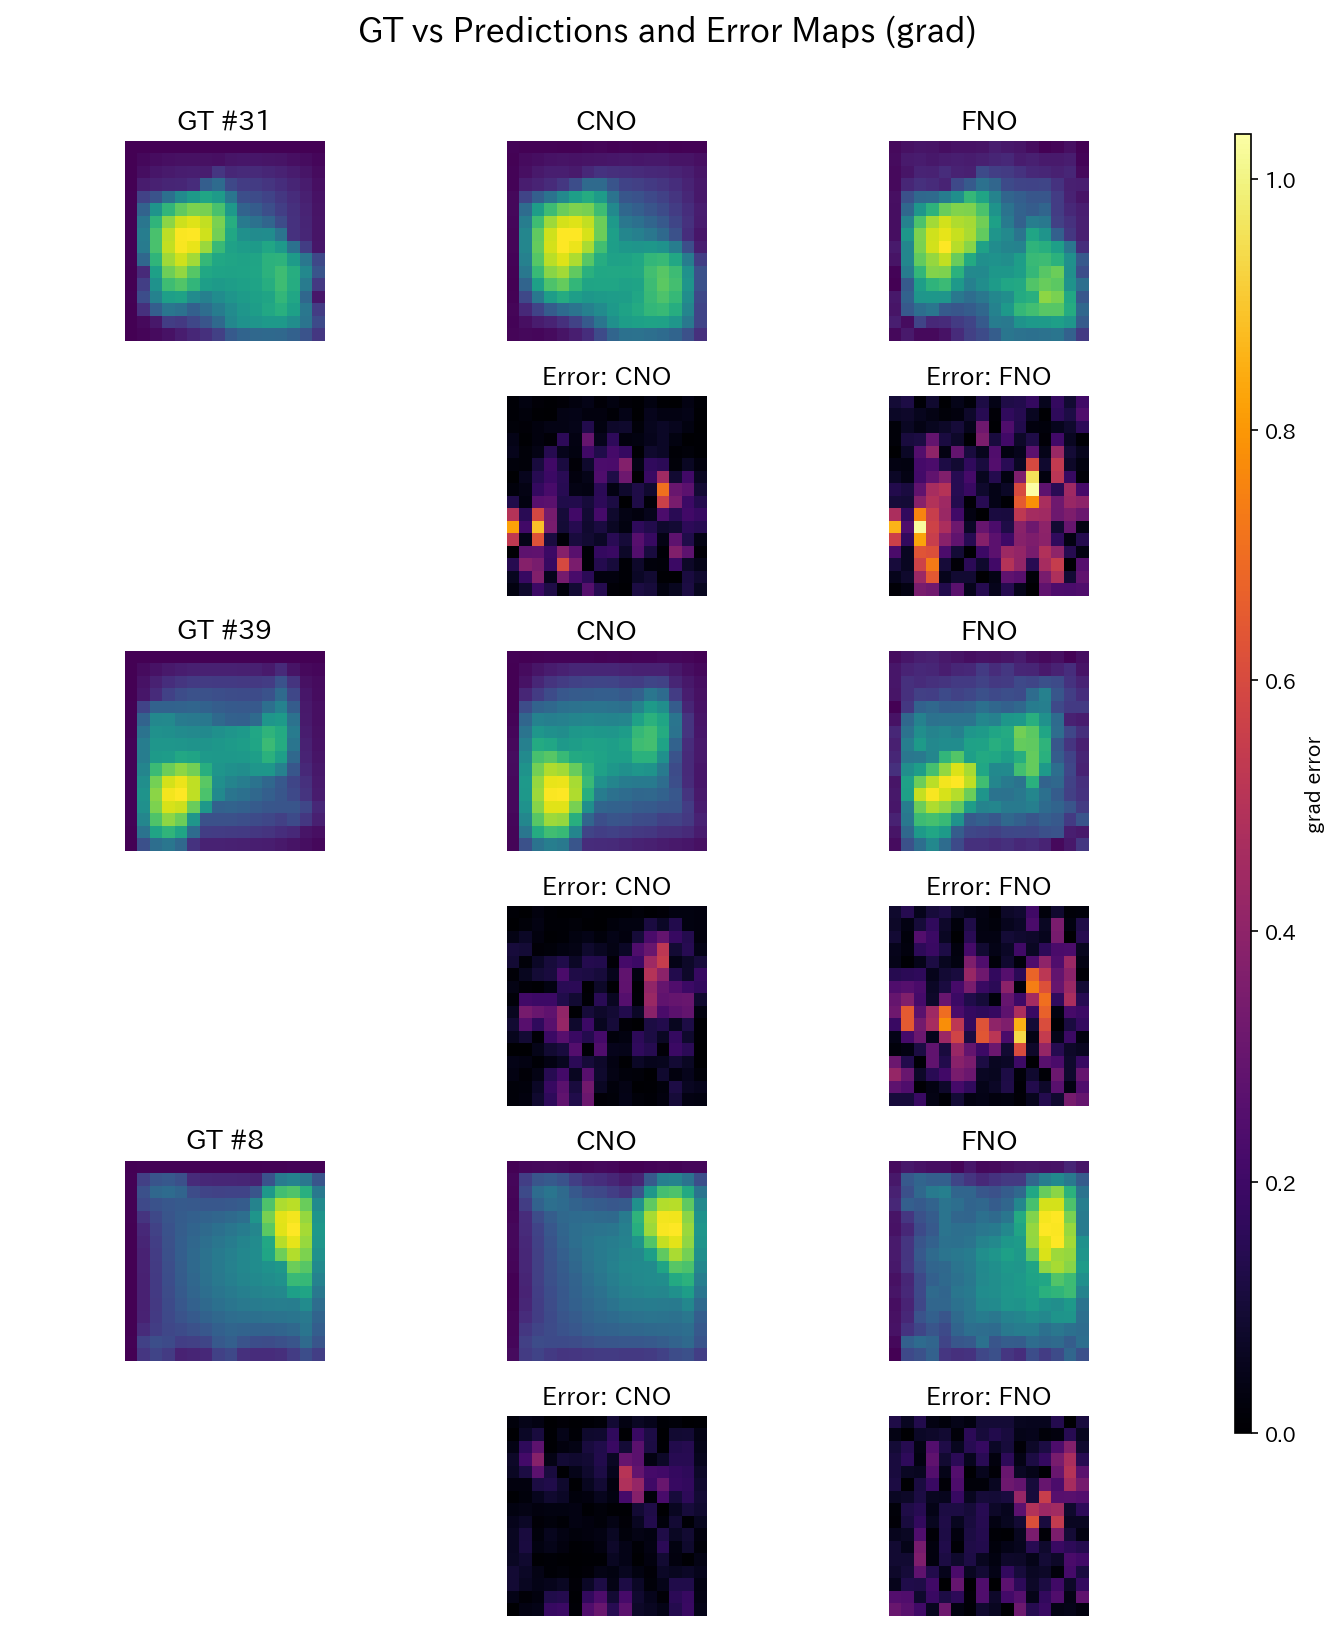

In [8]:
# visualize prediction error
error_type = "grad" # error_type = "abs", "square", "grad","ssim"から選択
plot_comparison_with_error_maps(gt_images,preds,labels, num_samples=3,error_type=error_type)

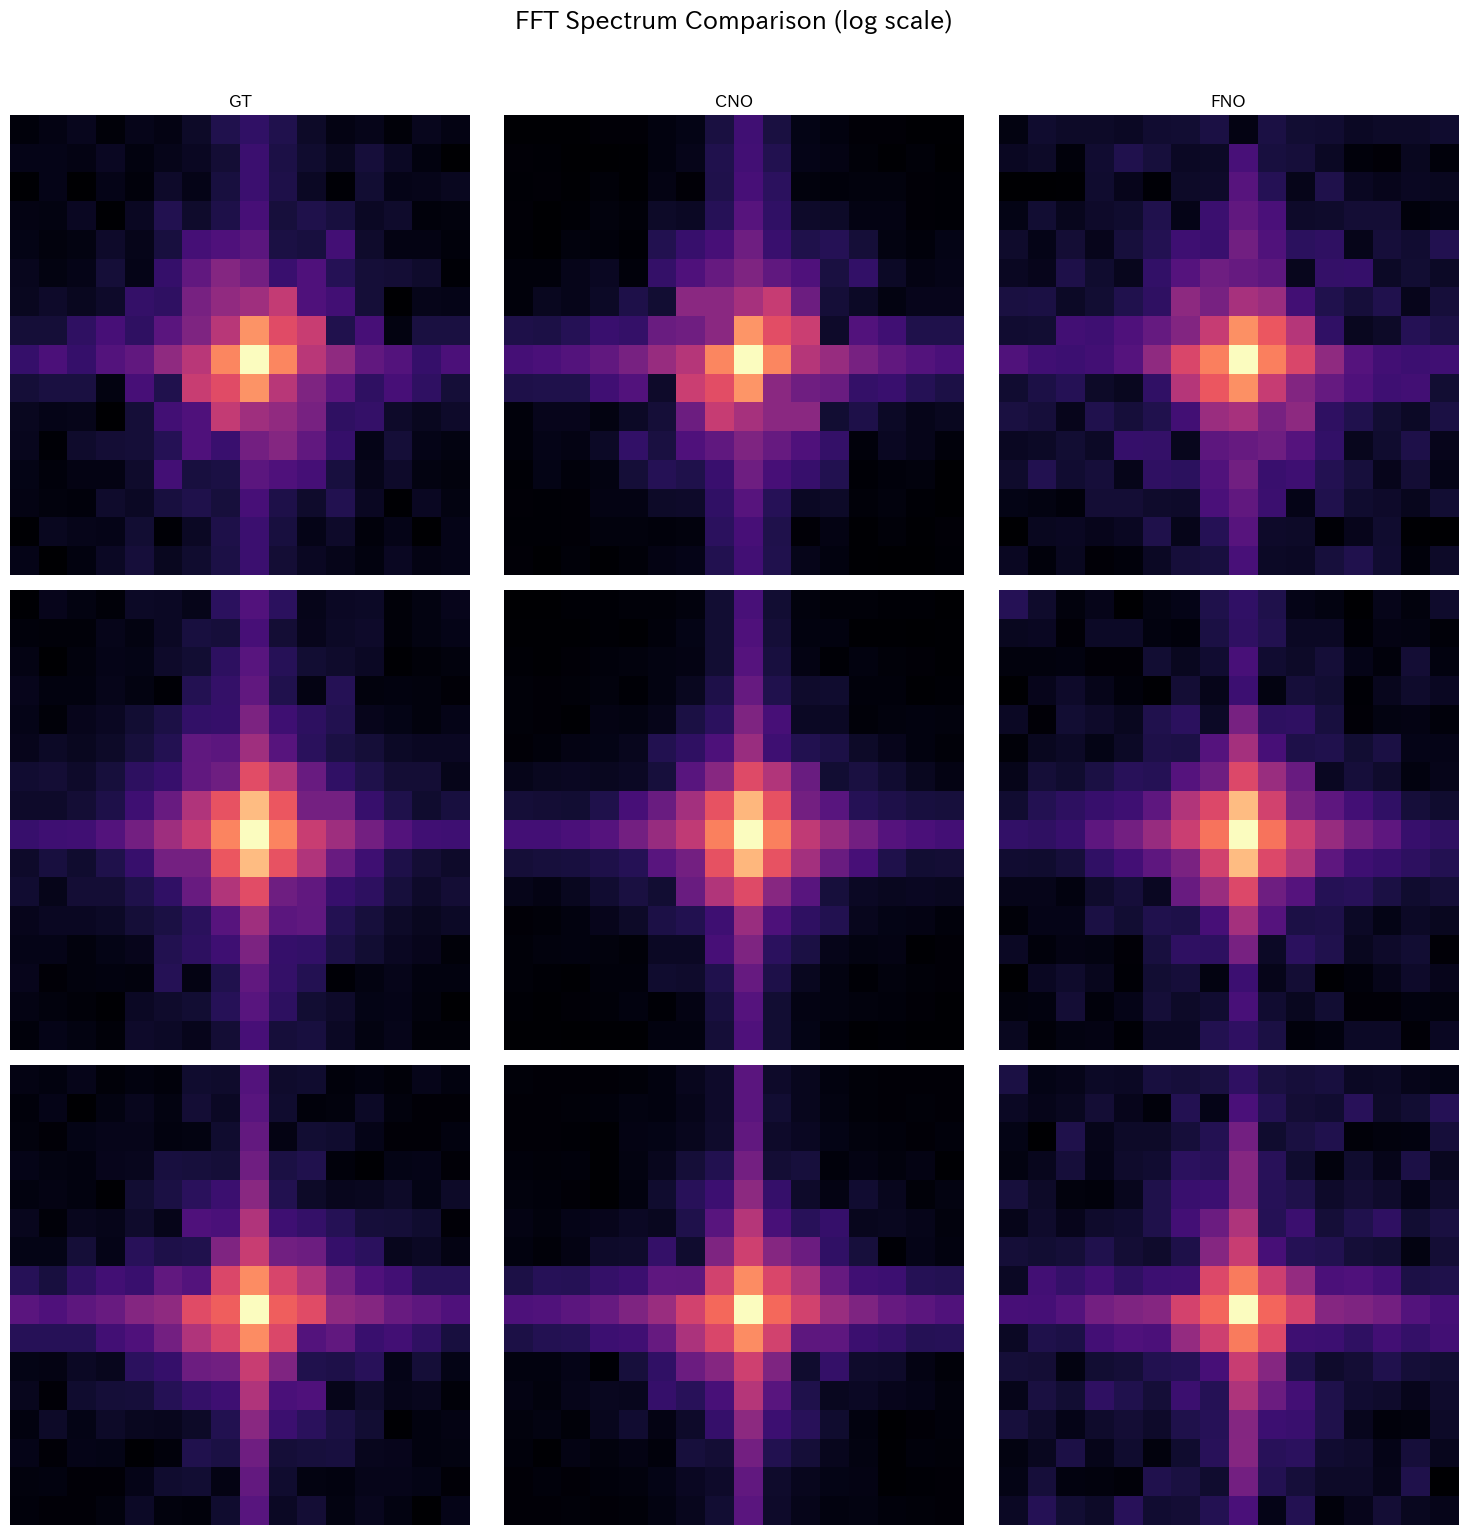

In [9]:
# visualize spectrum
compare_fft_spectra(
    gt_images=gt_images,
    pred_images_list=preds,
    labels_list=labels,
    num_samples=3
)

In [10]:
# inference test data(32x32)
inference_times_32 = {}
metrics_32 = {}

with torch.no_grad():
    # CNO
    pred_cno_32 = cno(x_test_32).cpu().numpy()
    inference_times_32["CNO"] = measure_inference_time(cno, x_test_32,warmup=10,repeat=1000)
    metrics_32["CNO"] = evaluate(pred_cno_32, y_test_32.cpu().numpy())

    # FNO
    x_test_fno_32 = x_test_32.permute(0, 2, 3, 1)  # (B, H, W, 1)
    pred_fno_32 = fno(x_test_fno_32).cpu().numpy()
    inference_times_32["FNO"] = measure_inference_time(fno, x_test_fno_32,warmup=10,repeat=1000)
    metrics_32["FNO"] = evaluate(pred_fno_32, y_test_32.cpu().numpy())


    y_true_32 = y_test_32.cpu().numpy()

print_inference_and_metrics(inference_times_32,metrics_32)


【評価結果】

【推論時間（ms）】
CNO            : 1.58 ms
FNO            : 1.98 ms

【評価指標】
Model                    MSE       PSNR       SSIM       HF_MSE
-----------------------------------------------------------------
CNO               2.2586e-01       6.46     0.6209   1.0565e+00
FNO               1.7411e-01      19.47     0.9122   1.7880e+02


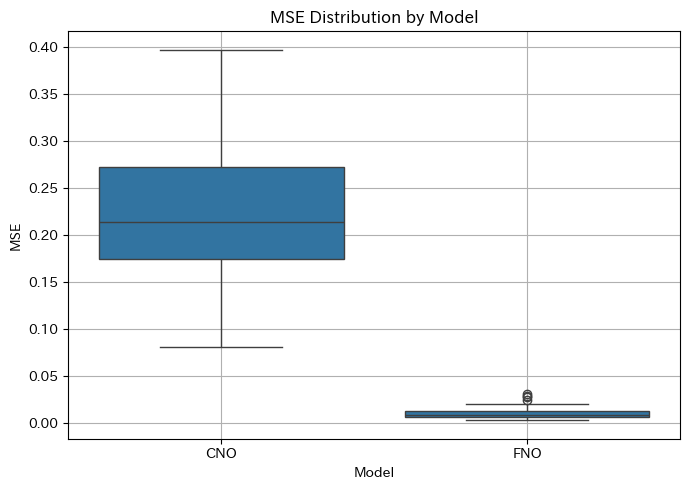

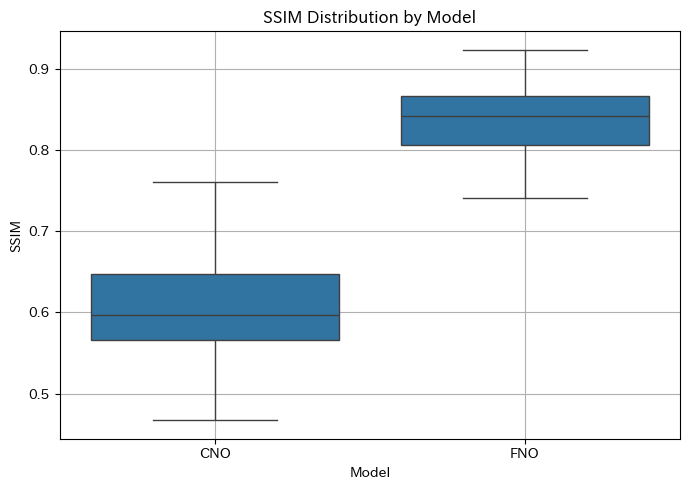

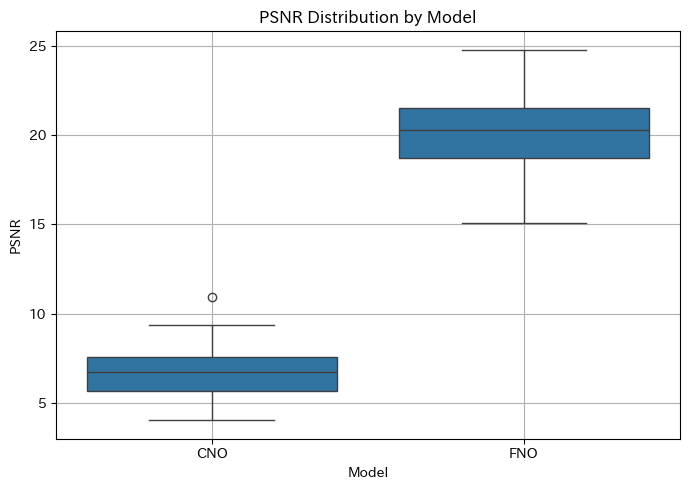

In [11]:
# evaluate per sample
scores_cno_32 = evaluate_all(pred_cno_32, y_test_32)
scores_fno_32 = evaluate_all(pred_fno_32, y_test_32)

mse_cno_32 = [s["MSE"] for s in scores_cno_32]
mse_fno_32 = [s["MSE"] for s in scores_fno_32]
ssim_cno_32 = [s["SSIM"] for s in scores_cno_32]
ssim_fno_32 = [s["SSIM"] for s in scores_fno_32]
psnr_cno_32 = [s["PSNR"] for s in scores_cno_32]
psnr_fno_32 = [s["PSNR"] for s in scores_fno_32]

boxplot_metric_comparison({"CNO": mse_cno_32, "FNO": mse_fno_32}, metric_name="MSE")
boxplot_metric_comparison({"CNO": ssim_cno_32, "FNO": ssim_fno_32}, metric_name="SSIM")
boxplot_metric_comparison({"CNO": psnr_cno_32, "FNO": psnr_fno_32}, metric_name="PSNR")



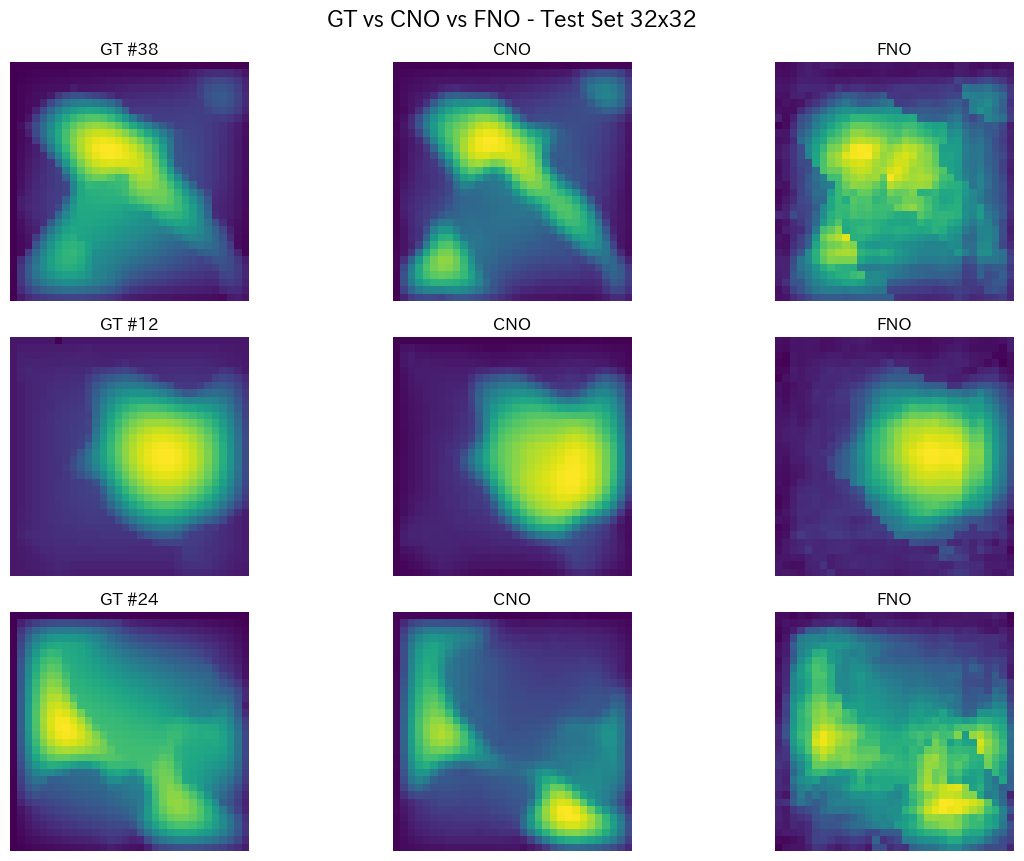

In [12]:
# visualize prediction samples
gt_images_32 = y_true_32.squeeze(1)                    # [B, 1, H, W] → [B, H, W]
cno_images_32 = pred_cno_32.squeeze(1)                 # [B, 1, H, W]
fno_images_32 = pred_fno_32.squeeze(-1)                # [B, H, W, 1]

preds_32 = [cno_images_32, fno_images_32]
labels_32 = ["CNO", "FNO"]


plot_gt_pred_comparison(gt_images_32,preds_32,labels_32,num_samples=3, title="GT vs CNO vs FNO - Test Set 32x32")


c:\Users\natsu\OneDrive - 国立大学法人東北大学\研究室\python\FNOorCNN\root\notebooks\evaluate_functions.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.94])


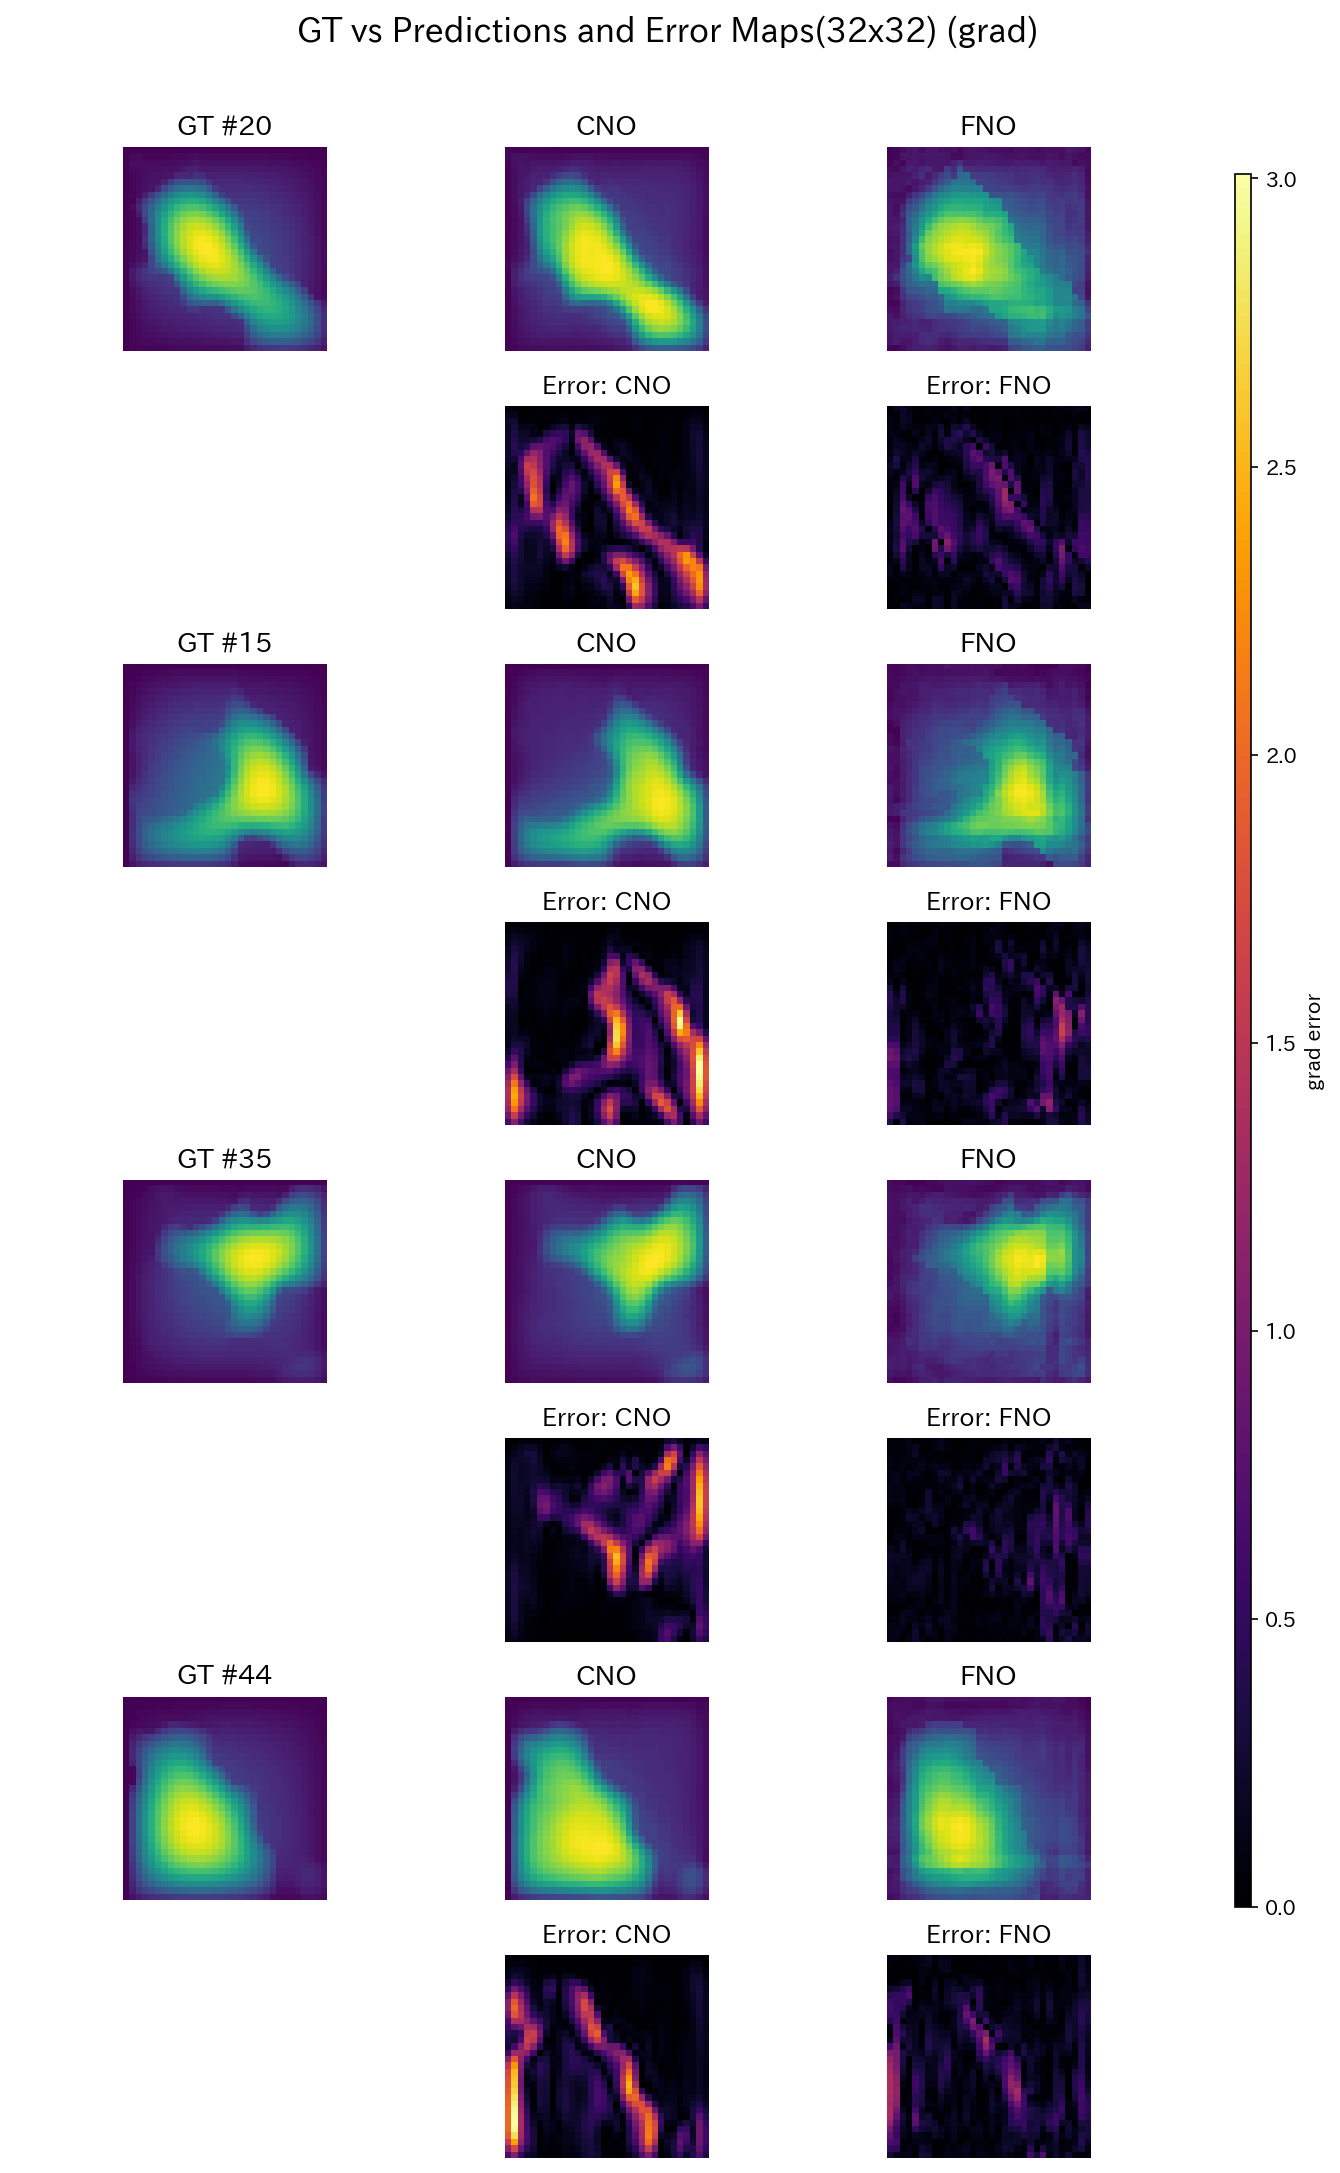

In [13]:
# visualize prediction error
error_type = "grad"  # error_type = "abs", "square", "grad","ssim"から選択
plot_comparison_with_error_maps(gt_images_32,preds_32,labels_32,num_samples=4, title = f"GT vs Predictions and Error Maps(32x32) ({error_type})",error_type=error_type)

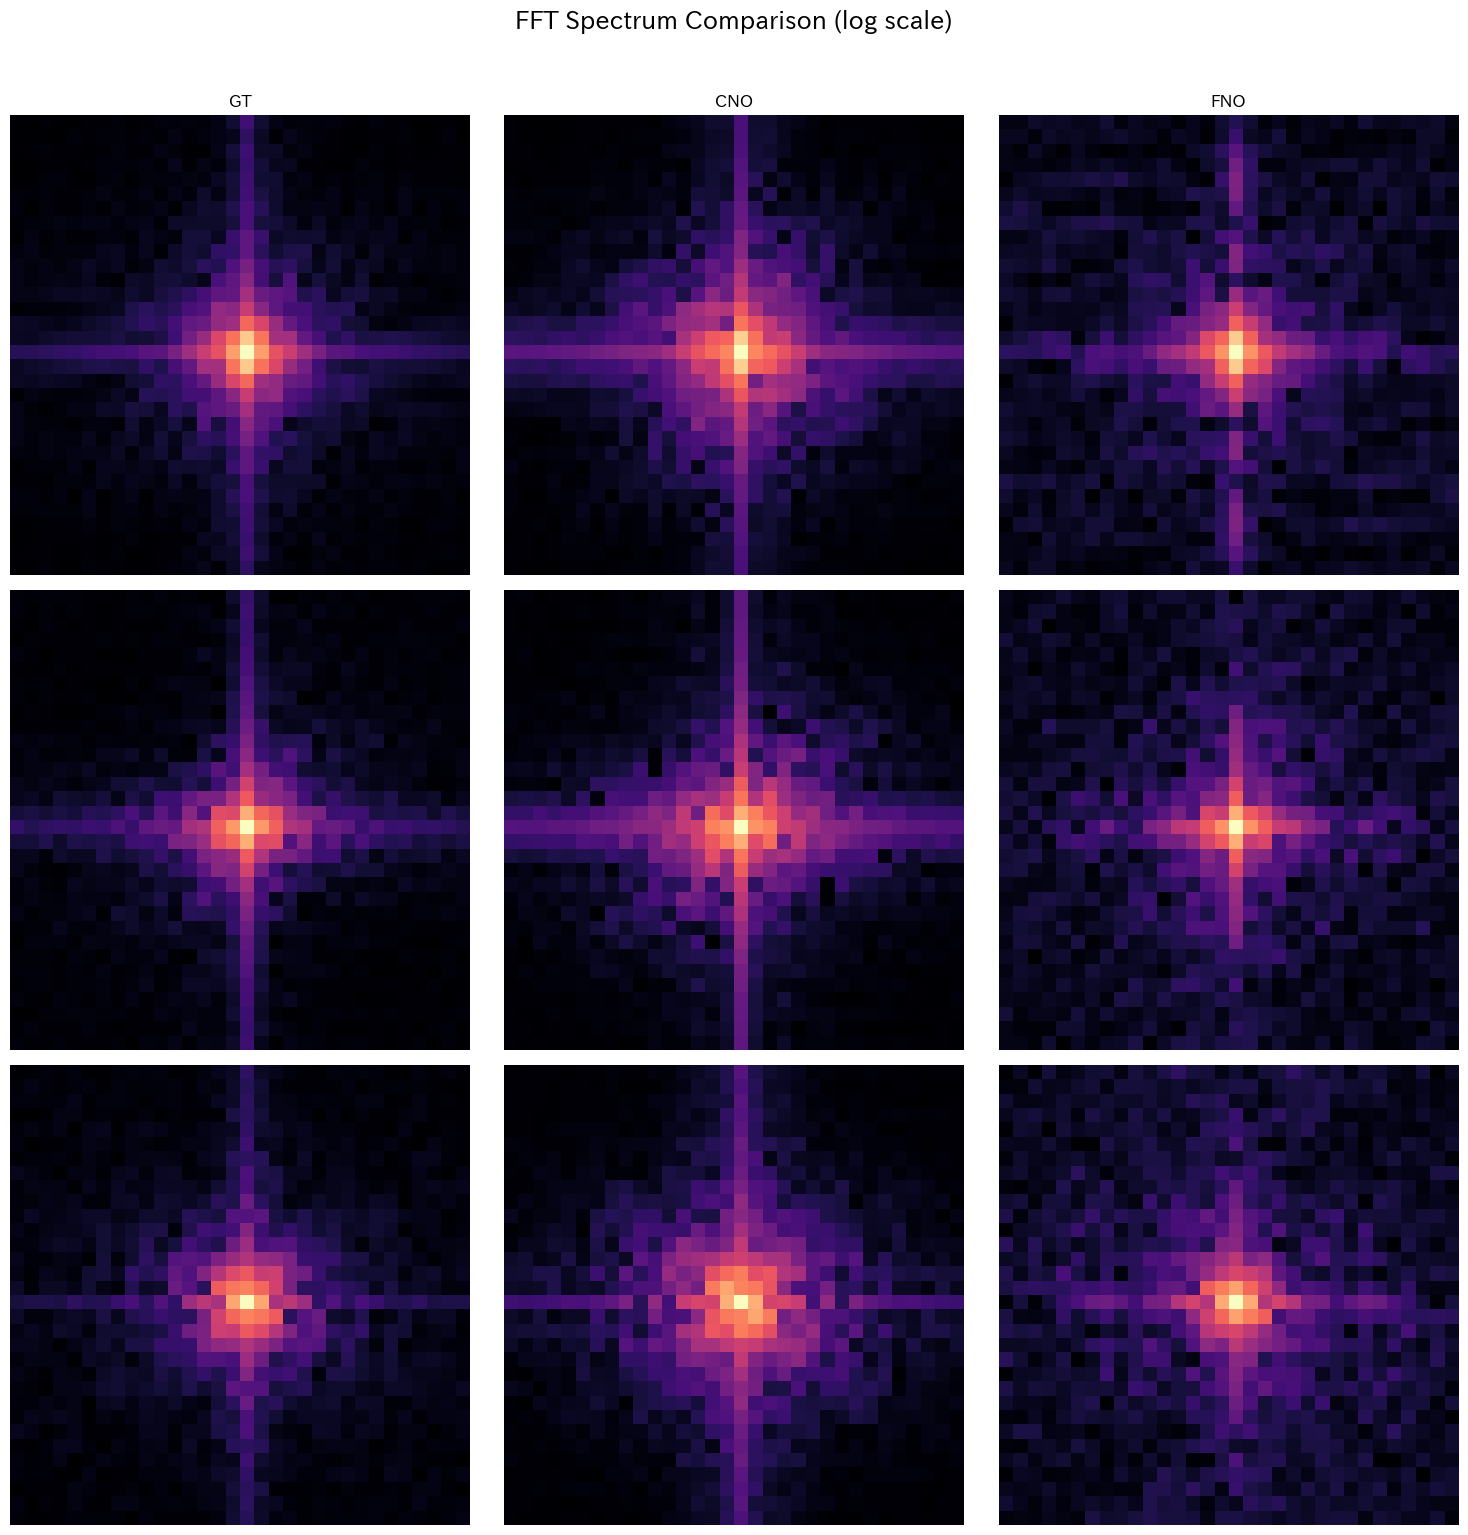

In [14]:
# visualize spectrum
compare_fft_spectra(
    gt_images=gt_images_32,
    pred_images_list=preds_32,
    labels_list=labels_32,
    num_samples=3
)